*Supporting textbook chapters for week 4: 6.1, 6.2, 6.3*

**Lecture 4, topics:**
* Solving linear systems
* Roots of nonlinear equations
* Minima: golden ratio search

# Solving linear systems

## Gaussian elimination

* In linear algebra courses, you learn to solve linear systems of the form
$$A x = v$$
using Gaussian elimination.
* This works pretty well in many cases. Let's do an example based on Newman's `gausselim.py`, for
$$A =
\begin{bmatrix}
6 & 5 \\
4 & 3
\end{bmatrix}, \qquad v = \binom{2}{1}$$

Refresher on Gaussian elimination (how `gausselim` works): the equation we need to solve is
$$\begin{bmatrix}
6 & 5 \\
4 & 3
\end{bmatrix}\binom{x_1}{x_2} = \binom{2}{1}$$
and therefore
$$6x_1 + 5x_2 = 2,$$
$$4x_1 + 3x_2 = 1$$
1. Divide 1st line by 1st (top-left) coefficient:
    $$x_1 + \frac56x_2 = \frac13,$$
    $$4x_1 + 3x_2 = 1$$

2. $4\times \text{1st eqn} - \text{2nd eqn} = \text{new 2nd eqn.}$:
    $$x_1 + \frac56x_2 = \frac13,$$
    $$0x_1 + \frac13x_2 = \frac13,$$
    and $x_2=1$.
    More eqns $\Rightarrow$ cancel all 1st coefficents of each line similarly.
    
3. (if more eqns: repeat from 2nd line to eliminate all 2nd coefficients below, and so on...)

4. (or 3.) Back-substitute: $x_2=1 \Rightarrow x_1 + 5/6 = 1/3 \Rightarrow x_1 = -1/2$.

In [5]:
import numpy as np
import gausselim_as_func as ge

A1 = np.array([[6, 5], [4, 3]], float)  
V1 = np.array([2, 1], float)

ge.gausselim(A1, V1)

[-0.5  1. ]


In [ ]:
# %load gausselim_as_func
from numpy import array, empty

def gausselim(A, v):
    N = len(v)
    # Gaussian elimination
    for m in range(N):
        # Divide by the diagonal element
        div = A[m, m]
        A[m, :] /= div
        v[m] /= div
        # Now subtract from the lower rows
        for i in range(m+1, N):
            mult = A[i, m]
            A[i, :] -= mult*A[m, :]
            v[i] -= mult*v[m]
    # Backsubstitution
    x = empty(N, float)
    for m in range(N-1, -1, -1):
        x[m] = v[m]
        for i in range(m+1, N):
            x[m] -= A[m, i]*x[i]
    print(x)

## When Gaussian elimination breaks down

The example below is a valid system but the original code will "break".
$$A =
\begin{bmatrix}
10^{-20} & 1 \\
1 & 1
\end{bmatrix}, \qquad v = \binom{1}{0}.$$
In theory, $\displaystyle x \approx \binom{-1}{1}$. But according to `gausselim`:

In [9]:
A2 = np.array([[1e-20, 1], [1, 1]], float)  # I imported np earlier
V2 = np.array([1, 0], float)

ge.gausselim(A2, V2)

[0. 1.]


Don't divide by (close to) zero!
* Had the top-left number actually been zero, Python would have thrown a `ZeroDivisionError`,
* with $10^{-20}<$ machine precision, no tripwire from Python, but rounding errors.

In [10]:
print("1/1e-20 =", 1/1e-20)  # possible because smaller than the biggest number representable

1/1e-20 = 1e+20


In [11]:
print("1/0", 1/0.)  # that on the other hand is too obvious

ZeroDivisionError: float division by zero

In [12]:
# In a previous python version, the following gave the right answer...
# ... but it now gives the same, wrong result.
np.linalg.solve(A2, V2)

array([0., 1.])

In [13]:
# SciPy does not give a better result ... but at least it gives a warning!
import scipy.linalg as la
la.solve(A2, V2)

/var/folders/7y/707b3rbx7dv9jch1hz6swz1w0000gn/T/ipykernel_51741/4139572006.py:2: LinAlgWarning: Ill-conditioned matrix (rcond=1e-40): result may not be accurate.
  la.solve(A2, V2)


array([0., 1.])

Not the topic of this lecture, but always be careful of the evolution of the packages!

**For this lab, it is possible that your results will differ, depending on the version of Python, NumPy, or both. Note that I cannot precisely know how, so, make sure your results make sense.**

## Partial pivoting: 

* Eliminates the issue of dividing by zero if diagonal entries become zero (or very close to zero)

**Algorithm outline:**
1. At $m^\text{th}$ row, check to see which of the rows below has the largest $m^\text{th}$ element (absolute value)
    * Swap this row with the current $m^\text{th}$ value
    * Proceed with Gaussian elimination 

In [15]:
A3 = np.array([[1, 1], [1e-20, 1]], float)  # swapped rows
V3 = np.array([0, 1], float)  # need to swap this one too

ge.gausselim(A3, V3)

[-1.  1.]


## LU Decomposition

### Motivation
Two pendulums, $A$ and $B$, of identical masses $m$ and lengths $\ell$, coupled by spring of stiffness $k$.
![Fig. 9: the symmetric normal mode, in the case $m_A = m_B$.](pendulum_asym.gif)

Two pendulums, $A$ and $B$, of identical masses $m$ and lengths $\ell$, coupled by spring of stiffness $k$.

Suppose each is driven differently:

$$ m\ddot x_A + \frac{mg}{\ell}x_A + k(x_A - x_B) = f_A\cos(\omega_1 t),$$

$$ m\ddot x_B + \frac{mg}{\ell}x_B -k(x_A - x_B) = f_B\cos(\omega_2 t),$$

* Can write these equations as $A x = f$.
* $A$ is always the same (depends on properties of pendulums and spring),
* but $f_A$, $f_B$, $\omega_1$, $\omega_2$ could change if the operator decides to change the driving.

The steps in the Gaussian elimination will always be the same: only need to do it once, then store.

Gaussian elimination on a matrix $A$ can be written as a series of matrix multiplications that yields $U = L_nL_{n-1}\cdots L_0A$, where $U$ is upper triangular (i.e., result of Gaussian elimination):

$$L^{-1} = L_n L_{n-1} \cdots L_0 \Rightarrow\ Ax =  LUx = f.$$

(see Newman pp. 222-224 for a $4\times4$ example; easy but long)

The decomposition
$$\boxed{LU = A}$$
is called the "LU decomposition" of the matrix $A$.

### How to use LU in practice

* Suppose you know $L$, $U$ from $A$.
* Then, $$Ax=f \Leftrightarrow Ux=L^{-1}f.$$
* Break down into **two triangular-matrix problems, $Ux=y$ and $Ly = f$**.
* Triangular $\Rightarrow$ back-substitution (pizza cake!)
* This method is used by `numpy.linalg.solve(A, f)`
* `scipy.linalg.lu_solve(scipy.linalg.lu_factor(A), f)` is equivalent to `numpy.linalg.solve(A, f)`, but intermediate steps give access to the decomposition and allow storage.
* Once you've done the LU decomposition of $A$, you don't need to do it again $\Rightarrow\ f$ can change over and over, $Ly=f$ is staightforward, and so is $Ux=y$.

### Issues with LU Decomposition

LU Decomposition fails when $A$ is close to singular, due to rounding error again.

For starters, take a matrix that is actually singular, e.g:
$$A = 
\begin{bmatrix}
    1 & 2 \\ 2 & 4
\end{bmatrix}$$
Depending on the RHS, we end up with either no solution, or one undetermined coefficient.

$A\binom{x_1}{x_2} = \binom{3}{5}\rightarrow $ can't have $x_1 + 2x_2 = 3$ and $= 5/2$ at the same time

$A\binom{x_1}{x_2} = \binom{3}{6}\rightarrow$ infinite number of solutions

So, LU won't find a solution when there is none: not really a drawback.
But what about 
$$A = 
\begin{bmatrix}
    1 & 2 \\ 2 & 4+\delta
\end{bmatrix},$$
with $\delta$ very small compared to other coefficients? 
Not singular, but LU won't work if $\delta$ is too small.

In [19]:
delta = 1e-16
A = np.array([[1, 2], [2, 4+delta]], float)
print(A)
v = np.array([3, 5], float)
np.linalg.solve(A, v)  # returns error if delta/4 < machine precision

[[1. 2.]
 [2. 4.]]


LinAlgError: Singular matrix

## QR decomposition for eigensystems

Looking for $\lambda$'s and $v$'s such that $Av = \lambda v$, 
with $v$ eigenvector, $\lambda$ eigenvalue

Or for $\Lambda$ and $V$ such that $AV = V\Lambda$, 
with $V$ orthonormal matrix of eigenvectors, $\Lambda$ diagonal matrix of eigenvalues

If $A$ is square and **either symmetric-real or Hermitian** (complex), we can solve this problem with a QR decomposition.

Don't get hung up on the details of the algorithm description below. Recall that it's iterative, and that it can break sometimes.

### QR algorithm

* Gram-Schmidt on columns of $A$ (Exercise 6.8) $\Rightarrow$ matrix of orthonormal basis of column vectors $Q$
* Denote QR decomposition of $A$ as $A = QR$, where $R$ is upper-triangular
* $Q$ orthonormal $\Rightarrow\ Q^TQ=I\ \Rightarrow\ R = Q^TA$.

Iterate:
* $A_1 = RQ = Q^TAQ$ --------------> Define $A_1$
* $A_1 = Q_1R_1$ ------------------------->  QR decomposition of $A_1$
* $A_2 = R_1Q_1 = \underbrace{Q_1^T\underbrace{Q^TA}_{R}Q}_{R_1}Q_1$ --> Define $A_2$
* $A_2 = Q_2R_2$ -------------------------> QR decomposition of $A_2$
* $A_3 = \dots$ 
... and so on, until obtaining an $A_k$ such that all off-diagnonal terms are small enough.

* Eventually, "it can be proven" that this iteration converges to a (near-)diagonal output $$A_k = \underbrace{(Q_k^T\cdots Q_1^TQ^T)}_{V^T\ (\text{because}\ Q_i^TQ_i = I)}A\underbrace{(QQ_1\cdots Q_k)}_V$$

$$\Rightarrow\ A_k  = V^TAV\ \Rightarrow\ \boxed{AV = VA_k}.$$

* diagonal entries of $A_k$ (off-diagonal entries are now tiny) are the eigenvalues: $\boxed{A_k=\Lambda}$.
* The eigenvectors are the columns of $\boxed{V=QQ_1\cdots Q_k}$



`numpy.linalg` implements the QR algorithm in the `numpy.linalg.eigh` function.

In [20]:
A = np.array([[2, 1], [1, 2]])  # imported numpy as np earlier

print('A:\n', A)

eig_vs, V = np.linalg.eigh(A)  # calculate eigenvalues & eigenvectors
L = np.diag(eig_vs)  # np.diag constructs a diagonal array

print('\neigenvalues: ', eig_vs)
print('eigenvectors:\n', V)

# we expect that AV = VD
print('\nAV:\n', np.dot(A, V))
print('VL:\n', np.dot(V, L))

A:
 [[2 1]
 [1 2]]

eigenvalues:  [1. 3.]
eigenvectors:
 [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]

AV:
 [[-0.70710678  2.12132034]
 [ 0.70710678  2.12132034]]
VL:
 [[-0.70710678  2.12132034]
 [ 0.70710678  2.12132034]]


### Be careful!

* `eigh` takes only Hermitian or real symmetric matrices as input
* What happens if we try a different (non-symmetric) matrix?

$$ A =
\begin{bmatrix}
2 & 3 \\
1 & 2
\end{bmatrix}$$


In [21]:
A = np.array([[2,3],[1,2]])
eig_vs, V = np.linalg.eigh(A) # calculate eigenvalues & eigenvectors
L = np.diag(eig_vs)  # np.diag constructs a diagonal array

print('AV:\n', np.dot(A, V))
print('VL:\n', np.dot(V, L)) 

AV:
 [[0.70710678 3.53553391]
 [0.70710678 2.12132034]]
VL:
 [[-0.70710678  2.12132034]
 [ 0.70710678  2.12132034]]


Result above should show that with $A$ is not a symmetric matrix: $AV \neq \Lambda V$. There are less efficient algorithms that will work with non-symmetric $A$.

In [22]:
A = np.array([[2,3],[1,2]])
eig_vs, V = np.linalg.eig(A) # calculate eigenvalues & eigenvectors
L = np.diag(eig_vs)  # np.diag constructs a diagonal array

print('AV:\n', np.dot(A, V))
print('VL:\n', np.dot(V, L)) 

AV:
 [[ 3.23205081 -0.23205081]
 [ 1.8660254   0.1339746 ]]
VL:
 [[ 3.23205081 -0.23205081]
 [ 1.8660254   0.1339746 ]]


# Finding roots of nonlinear equations

Newman discusses several methods of this: Relaxation, Newton's method, bisection...

Let's review.


## Relaxation

* Solving for $x$ in an equation $x = f(x)$
* Guess an initial value $x_0$ and iterate until the function converges to a fixed point

$$x_1 = f(x_0)$$
$$x_2 = f(x_1)$$
$$\vdots$$

* Caveat: Can only find *stable* fixed points

![Relaxation method to find the intersection of $cos(s)=x$: start at $x_0=-1$, define $x_1=\cos(x_0)$, then $x_2 = \cos(x_1)$, and so on until converging. CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=2037027](Cosine_fixed_point.png)

Let's do an example: find the (positive) solution to $\tanh(2x) = x$.

![](tanh2x_eq_x.pdf)

In [3]:
import numpy as np
def f(x):
    return np.tanh(2*x)

x = 0.5  # initial x guess
dx = 1  # initial distance (just needs to be big)
threshold = 1e-10  # convergence threshold
x_list = [x]  # will fill up with successive x's

while dx > threshold:
    x_list.append(f(x_list[-1]))
    dx = np.abs(x_list[-1]-x_list[-2])
print(x_list[-1])

0.9575040240732228


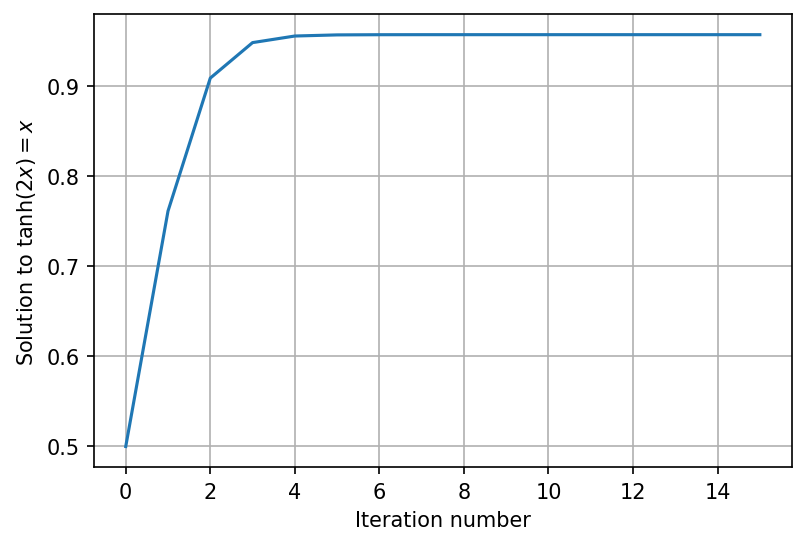

In [4]:
def print_sol():
    import matplotlib.pyplot as plt
    plt.figure(dpi=150)
    plt.plot(x_list)
    plt.xlabel("Iteration number")
    plt.ylabel(r"Solution to $\tanh(2x)=x$")
    plt.grid()
    
print_sol()

## Newton's method

Solving for $x$ in $f(x) = 0$
1. Start with some value $x_1$, calculate tangent $f'(x_1)$
2. Travel along tangent line to intersection with $x$-axis at $x_2$
3. Repeat (calculate tangent $f'(x_2)$, etc.)

Mathematically:
$$x_{n+1} = x_n-\frac{f(x_n)}{f'(x_n)}$$

**Secant method:** If analytic form of $f$ is unknown, calculate $f'(x)$ numerically - suggest using forward or backward difference, to avoid re-computing yet another $f(x_k)$

![By Ralf Pfeifer - de:Image:NewtonIteration Ani.gif, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=2268473](NewtonIteration_Ani.gif)

**Pro:**
* Much faster than relaxation

**Cons:**
* Need to know $f'$ (although this issue is addressed by the secant method)
* Doesn't always converge
    * need to have good initial guess (like relaxation),
    * small $f'$ gives $x_{n+1}$ much farther away,
    * sometimes, it just does not converge. Period. (e.g., fractals)

## Bisection (or Binary Search)

* Bracket a single root on either side of the zero of the function $(x_1,x_2)$
* Use midpoint $x'$ as subsequent bracket 
* Choose brackets depending on the sign of the value at the midpoint; 
     - For this example, $f(x_1)>0$, $f(x') < 0$, so the next set of brackets is $(x_1,x')$

<img src="bisect.png" width="500">

(Newman's fig. 6.3)

**Pro:**
* Incredibly easy to remember, therefore to implement
* When there's a root, there's a way (no worries about converging towards at least *a* root)

**Cons:**
* Only works with a single bracketed root
* Can't find "double roots" where $f(x)$ reaches but does not cross 0 (think $f(x)=x^2$)
* Can't find even one root when there is an even number of roots.
* Large sample intervals can "miss" roots
* Slower than Newton

### Convergence characteristics

![](ConvergenceRoots.png)

# Finding minima/maxima

* Many ways to do this

* This week's example: Golden Ratio search

## Golden ratio search

Similar to binary search: find minimum by shrinking intervals

1. Start with 2 points $x_1, x_4$ bracketing the interval
2. Choose 2 points $x_2,x_3$ inside the interval
* Check which of $f(x_2)$ and $f(x_3)$ is lower to determine new brackets
    * In this example: $f(x_2)<f(x_3) \Rightarrow$ new interval is $[x_1, x_3]$

Use the golden ratio to determine the most optimal placement of the internal points $x_1, x_2$

![Newman's fig. 6.9](fig6-9.png)

## Golden ratio search: intuition

* Interior points $x_2$, $x_3$ must be symmetric about the midpoint of the interval (why favour one side vs. the other?)
* If you place interior points close (distance $\epsilon$) to the centre of interval:
    * you'll divide your search interval by $\approx2$ (very good), but 
    * next step will be difficult: new "interior" point will be bar from new centre, next step will only divide the search interval by $\approx 1-\epsilon$ (very bad)
* If you place interior points close to edges creates the opposite: first step very bad, next step very good
* **Solution**: find sweet spot(s) to make sure the search interval is divided by same ratio each time.
* See pp. 281-282 of textbook for explanation of why this ratio needs to be $$z = \frac{1+\sqrt5}2 \approx 1.618$$ the *Golden Ratio*.
    I.e., $x_4-x_1 = (x_3-x_1)z = (x_4-x_2)z$.



# Summary

**Finding solutions of linear systems** $Ax = v$
* Gaussian elimination if you know the 1st coefficient will always be OK
* Partial pivot to be safe: re-order equations such that biggest first coefficient shows up first
* LU decomposition is strictly the same as Partial pivot, but storing $L$ and $U$ saves times when $A$ stays the same but $v$ changes often

**Finding eigenvalues/eigenvectors**
* Matrix is real symmetric or Hermitian: QR algorithm is iterative (can take time to converge) but efficient.
* Otherwise: SciPy will find them for you if patient.

**Finding roots of nonlinear equations**
    $$f(x) = 0 \quad\text{or}\quad  f(x)-x=0$$
* Relaxation for $f(x)=x$ is easy but works only for stable fixed points
* Newton's method is super fast but you need a good initial guess and confidence that a root exists
* Binary search is easy, converges slowly, has a lot of caveat (double roots, need a good initial bracket...)

**Finding minima/maxima**: Golden ratio search, slow and suffers from same limitations as binary search, but works.